In [1]:
from builtins import range, map, zip, filter
from io import open
import six,imp,os,sys
from six.moves import cPickle
import h5py
import numpy as np 
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold , train_test_split
# from skimage.transform import resize
import keras
from keras.datasets import mnist,cifar10,fashion_mnist
from keras.models import Sequential,Model,load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten,Conv1D, Conv2D, Convolution2D, MaxPooling1D,MaxPooling2D,Permute
from keras.layers import GlobalAveragePooling2D, CuDNNGRU,CuDNNLSTM,LSTM#,AtrousConv2D
from keras.layers.normalization import BatchNormalization
from keras.applications import densenet,resnet50
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input, decode_predictions
import keras.applications.vgg16 as vgg16
from keras.utils import plot_model
from matplotlib import pyplot as plt
from keras.losses import MAE
from keras.optimizers import SGD, Adam, adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow import set_random_seed
# from PIL import Image
from numpy.random import seed
keras.__version__
# seed(639)
# set_random_seed(5944)

Using TensorFlow backend.


'2.3.1'

# kera-LSUV初始化

In [29]:
def svd_orthonormal(shape):
    # Orthonorm init code is taked from Lasagne
    # https://github.com/Lasagne/Lasagne/blob/master/lasagne/init.py
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q


def get_activations(model, layer, X_batch):
    intermediate_layer_model = Model(
        inputs=model.get_input_at(0),
        outputs=layer.get_output_at(0)
    )
    activations = intermediate_layer_model.predict(X_batch)
    return activations


def LSUVinit(model, batch, verbose=True, margin=0.1, max_iter=10):
    # only these layer classes considered for LSUV initialization; add more if needed
    classes_to_consider = (Dense, Convolution2D)

    needed_variance = 1.0

    layers_inintialized = 0
    for layer in model.layers:
        if verbose:
            print(layer.name)
        if not isinstance(layer, classes_to_consider):
            continue
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(layer.get_output_shape_at(0)[1:]) < 32:
            if verbose:
                print(layer.name, 'too small')
            continue
        if verbose:
            print('LSUV initializing', layer.name)

        layers_inintialized += 1
        weights_and_biases = layer.get_weights()
        weights_and_biases[0] = svd_orthonormal(weights_and_biases[0].shape)
        layer.set_weights(weights_and_biases)
        activations = get_activations(model, layer, batch)
        variance = np.var(activations)
        iteration = 0
        if verbose:
            print(variance)
        while abs(needed_variance - variance) > margin:
            if np.abs(np.sqrt(variance)) < 1e-7:
                # avoid zero division
                break

            weights_and_biases = layer.get_weights()
            weights_and_biases[0] /= np.sqrt(variance) / np.sqrt(needed_variance)
            layer.set_weights(weights_and_biases)
#             weights /= np.sqrt(variance) / np.sqrt(needed_variance)
#             layer.set_weights([weights, biases])
            activations = get_activations(model, layer, batch)
            variance = np.var(activations)

            iteration += 1
            if verbose:
                print(variance)
            if iteration >= max_iter:
                break
    if verbose:
        print('LSUV: total layers initialized', layers_inintialized)
    return model

In [18]:
# model=load_model('pure_cnn_model_mnist_0-1.h5')
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 归一化
# x_train = x_train / 255.0
# x_test = x_test / 255.0
# #     x_train = preprocess_input(x_train,mode='tf')
# #     x_test = preprocess_input(x_test,mode='tf')
# # 标签激活
# y_train = keras.utils.to_categorical(y_train, 10)
# y_test = keras.utils.to_categorical(y_test, 10)
# x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], x_train.shape[2], 1))
# x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1], x_test.shape[2], 1))
aa=x_test[0,:,:,:]
ww = aa.reshape((1,28,28,1))
model=load_model('cifar_cnn_maxpool.h5')
# model=load_model('./same_s7_k4_cnn.h5')
# model=load_model('./same_s1_k3_cnn.h5')

# pp = Image.open("./perturbed_image7.jpg")
# pp= np.reshape(pp,(1,784))
# print(pp)
model.predict(ww)
# ww
# ks = model.layers[1].get_weights()
# w = ks[0]
# b = ks[1]
# print(w.shape,b.shape)
# mykernel = w[:,:,0,0]
# print(mykernel)


array([[0.        , 0.        , 0.        , 0.00000001, 0.        , 0.        , 0.        , 1.        , 0.        , 0.        ]], dtype=float32)

In [57]:
model=load_model('cifar_valid_s2_k3_cnn.h5')
t1,t2,x_test,y_test=preprocessing_data()
for index,layer in enumerate(model.layers):
    print(layer.name)
intermediate_model = Model(inputs = model.input,outputs = model.get_layer('dense_26').output)
out = intermediate_model.predict(np.reshape(x_test[0],(1,x_test[0].shape[0],x_test[0].shape[1], 3)))
print(out.shape)
# print(out[0,:,:,0])
print(out)
# print(model.predict(np.reshape(x_test[0],(1,x_test[0].shape[0],x_test[0].shape[1], 3))))


(50000, 32, 32, 3)
conv2d_36
dropout_13
conv2d_37
dropout_14
flatten_13
dense_25
dropout_15
dense_26
(1, 10)
[[0.0001558  0.00001518 0.00008591 0.9930757  0.00002154 0.00530663 0.00065563 0.00022137 0.00045099 0.00001113]]


In [79]:
weights = [[[0.42761427 ,0.42761427 ,0.42761427 ,0.42761427],
 [0.42761427 ,0.8159478  ,1.452899   ,0.53031933],
 [0.42761427 ,0.42761427 ,2.2135863  ,0.42761427],
 [0.42761427 ,0.67619896 ,0.13113204 ,0.42761427]],
[[0.04829188 ,0.04829188 ,0.04829188 ,0.04829188],
 [0.04829188 ,2.6751187  ,2.6916704  ,0.851653  ],
 [0.04829188 ,0.04829188 ,2.6460803  ,0.04829188],
 [0.04829188 ,0.13802311 ,1.3577688  ,0.04829188]]]

weights = np.array(weights)

np.sum(weights[0]*mykernel)+b[0]


1.5325851838355151

In [20]:
def get_mnist_cnn():
    batch_size = 128
    nb_classes = 10  # 分类数
    nb_epoch = 12  # 训练轮数
    # 输入图片的维度
    img_rows, img_cols = 28, 28
    # 卷积滤镜的个数
    nb_filters, nb_filters2 = 16, 32
    pool_size = (2, 2)
    kernel_size = (4, 4)
    input_shape = (img_rows, img_cols, 1)
    stride = 2
    strides = (stride, stride)
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
     # 归一化
    x_train = x_train / 255.0
    x_test = x_test / 255.0
#     x_train = preprocess_input(x_train,mode='tf')
#     x_test = preprocess_input(x_test,mode='tf')
    # 标签激活
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], x_train.shape[2], 1))
    x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1], x_test.shape[2], 1))

    print(x_train.shape)
    # 开始自定义组合神经网络结构
#     mpadding = 'valid'
    mpadding = 'same'
    model = Sequential()
    model.add(Convolution2D(nb_filters, kernel_size, strides=strides, padding=mpadding, activation='relu', input_shape=input_shape))
#     model.add(MaxPooling2D())
    model.add(Convolution2D(nb_filters2, kernel_size, strides=strides, padding=mpadding, activation='relu'))
    model.add(Flatten())
    # model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    # 拟合数据集，开始训练
    model.fit(x_train, y_train, batch_size=batch_size, epochs=5)
#     model.fit(x_train,y_train,batch_size=batch_size,epochs=nb_epoch,validation_data=(x_test,y_test))

    # 评估模型
    score = model.evaluate(x_test,y_test)
    print("LOSS:",score[0],"ACCU:",score[1])
#     return model
    # 保存模型
    model.save('pure_cnn_model_mnist_0-1.h5')
get_mnist_cnn()

(60000, 28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 16)        272       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          8224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               156900    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 166,406
Trainable params: 166,406
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
60000/60000 [==============================] - 9s 147us/step - loss: 0.2859 - acc: 0.9191
Epoch 2/5
60000/6

In [ ]:
def get_mlp():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # 变成一维进行全连接层的网路训练
    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)
    # 归一化
    x_train = x_train / 255
    x_test = x_test / 255
    # 标签激活
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    # 构建模型
    model = Sequential()
    model.add(Dense(24, activation='relu', input_shape=(784,)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    # 显示网络结构
    model.summary()
    # 编译
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # 拟合数据集，开始训练
    model.fit(x_train,y_train,batch_size=64,epochs=30,validation_data=(x_test,y_test))
    # 评估模型
    score = model.evaluate(x_test,y_test)
    print("LOSS:",score[0],"ACCU:",score[1])
    # 保存模型
    model.save('fashion_mnist_model_2_24.h5')

# get_mlp()
    

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# 变成一维进行全连接层的网路训练
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
# 归一化
x_train = x_train / 255
x_test = x_test / 255
# 标签激活
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

model=load_model('fashion_mnist_model_2_24.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# 拟合数据集，开始训练
model.fit(x_train,y_train,batch_size=64,epochs=30,validation_data=(x_test,y_test))
# 评估模型
score = model.evaluate(x_test,y_test)
print("LOSS:",score[0],"ACCU:",score[1])
model.save('fashion_mnist_model_2_24.h5')

In [33]:

def preprocessing_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    print(x_train.shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
     # 归一化
    x_train = x_train / 255
    x_test = x_test / 255
#     x_train = preprocess_input(x_train,mode='torch')
#     x_test = preprocess_input(x_test,mode='torch')
#     x_train = preprocess_input(x_train,mode='tf')
#     x_test = preprocess_input(x_test,mode='tf')
    # 标签激活
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    return x_train, y_train, x_test, y_test

def get_cifar_cnn():
    x_train, y_train, x_test, y_test = preprocessing_data()
    batch_size = 128
    nb_classes = 10
    nb_epoch = 5
    img_rows, img_cols, img_channels = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    nb_filters, nb_filters2 = 16, 32
    pool_size = (2, 2)
    kernel_size = (3, 3)
    input_shape = (img_rows, img_cols, img_channels)
    stride = 1
    strides = (stride, stride)
#     mpadding = 'valid'
    mpadding = 'same'
    model = Sequential()
    model.add(Convolution2D(nb_filters, kernel_size, strides=strides, padding=mpadding, activation='relu', input_shape=input_shape))
    model.add(Convolution2D(nb_filters, kernel_size, strides=strides, padding=mpadding, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Convolution2D(nb_filters2, kernel_size, strides=strides, padding=mpadding, activation='relu'))
    model.add(Convolution2D(nb_filters2, kernel_size, strides=strides, padding=mpadding, activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    model = LSUVinit(model,x_train[:batch_size,:,:,:])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epoch, validation_data=(x_test,y_test), shuffle=True)
    score = model.evaluate(x_test,y_test)
    print("LOSS:",score[0],"ACCU:",score[1])
    model.save('cifar_cnn_maxpool.h5')
    
get_cifar_cnn()


(50000, 32, 32, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0 

In [7]:
x_train, y_train, x_test, y_test = preprocessing_data()
# 变成一维进行全连接层的网路训练
x_train = x_train.reshape(50000, 32*32*3)
x_test = x_test.reshape(10000, 32*32*3)
model = load_model('cifar_model_3_24.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# 拟合数据集，开始训练
model.fit(x_train,y_train,batch_size=128,epochs=60,validation_data=(x_test,y_test))
# 评估模型
score = model.evaluate(x_test,y_test)
print("LOSS:",score[0],"ACCU:",score[1])
model.save('cifar_model_3_24.h5')

(50000, 32, 32, 3)
Train on 50000 samples, validate on 10000 samples
Epoch 1/60
50000/50000 [==============================] - 2s 44us/step - loss: 1.7455 - acc: 0.3689 - val_loss: 1.7281 - val_acc: 0.3737
Epoch 2/60
50000/50000 [==============================] - 1s 24us/step - loss: 1.7417 - acc: 0.3709 - val_loss: 1.7367 - val_acc: 0.3675
Epoch 3/60
50000/50000 [==============================] - 1s 24us/step - loss: 1.7387 - acc: 0.3723 - val_loss: 1.7413 - val_acc: 0.3658
Epoch 4/60
50000/50000 [==============================] - 1s 25us/step - loss: 1.7386 - acc: 0.3708 - val_loss: 1.7415 - val_acc: 0.3643
Epoch 5/60
50000/50000 [==============================] - 1s 29us/step - loss: 1.7355 - acc: 0.3728 - val_loss: 1.7303 - val_acc: 0.3688
Epoch 6/60
50000/50000 [==============================] - 1s 24us/step - loss: 1.7362 - acc: 0.3714 - val_loss: 1.7405 - val_acc: 0.3664
Epoch 7/60
50000/50000 [==============================] - 1s 24us/step - loss: 1.7393 - acc: 0.3721 - val_los

Epoch 60/60
10000/10000 [==============================] - 0s 20us/step
LOSS: 1.7250324214935302 ACCU: 0.376


In [24]:
# eran测试数据集文本写出

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = x_train.reshape(60000, 784)
# print(x_test[0])
x_test = x_test.reshape(10000, 784)


test_imgs = []
import copy
with open('mytestdataset.csv', 'w') as fs:
    for i in range(100):
        arr = copy.copy(x_test[i].tolist())
        arr.insert(0,y_test[i])
        arr = [str(x) for x in arr]
#         test_imgs.append(','.join(arr))
        fs.write(','.join(arr)+'\n')
# df = pd.DataFrame(test_imgs)

# df = df.append(,ignore_index=True)
# df.to_csv('mytestdataset.csv',index=False, header=False)

# print(arr)
# print([y_test[0]]+x_test[0])


(32, 32, 3)


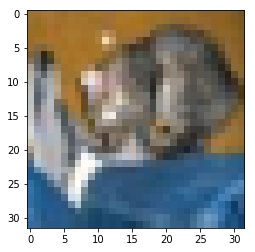

In [13]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_test[1].shape)
plt.imshow(x_test[0])

# h5转Eran格式

In [95]:

# 保证所有数据能够显示，而不是用省略号表示，np.inf表示一个足够大的数
np.set_printoptions(threshold = np.inf) 
# 若想不以科学计数显示:
np.set_printoptions(suppress = True)
np.set_printoptions(linewidth = np.inf)

    
def get_name_map():
    return {'conv2d':'Conv2D','max_pooling2d':'MaxPooling2D','sigmoid':'Sigmoid',\
            'relu':'ReLU','linear':'Affine','tanh':'Tanh','softmax':'Affine'}

def extract_con2d(fs,layer):
    weights = layer.get_weights()
    filters = layer.filters
    kernel_size = list(layer.kernel_size)
    input_shape = list(layer.input_shape)
    if len(input_shape)==4:
        input_shape = input_shape[1:]
    strides = list(layer.strides)
    fs.write('Conv2D\n')
    name_map = get_name_map()
    name = layer.activation.__name__.lower()
    fs.write(name_map[name]+',')
    fs.write('filters='+str(filters)+',')
    fs.write('kernel_size='+str(kernel_size)+',')
    fs.write('input_shape='+str(input_shape)+',')
    fs.write('stride='+str(strides)+',')
    #   tf中padding=='same'表示全填充,valid表示不填充，padding=0表示不填充,padding=1四周都填充
    if layer.padding.lower()=='same':
        fs.write('padding=1\n')
    else: 
        # valid
        fs.write('padding=0\n')
    fs.write(str(weights[0].tolist())+'\n')
    fs.write(str(weights[1].tolist())+'\n')

def extract_max_pooling(fs,layer):
    weights = layer.get_weights()
    pool_size = list(layer.pool_size)
    input_shape = list(layer.input_shape)
    if len(input_shape)==4:
        input_shape = input_shape[1:]
    strides = list(layer.strides)
    fs.write('MaxPooling2D\n')
    fs.write('pool_size='+str(pool_size)+',')
    fs.write('input_shape='+str(input_shape)+'\n')
#     fs.write('stride='+str(strides)+'\n')

def extract_dense_activation(fs,layer):
    weights = layer.get_weights()
    name_map = get_name_map()
    name = layer.activation.__name__.lower()
    #if name in ['sigmoid','tanh','softmax']:
    fs.write(name_map[name]+'\n')
    global has_permute
    global permute_shape
    print(has_permute,permute_shape)
    if has_permute:
        has_permute = False
        wp = dict()
        length = weights[0].shape[0]
        warr = np.zeros(length)
        new_w = np.zeros(weights[0].shape)
        for i in range(length):
            wp[weights[0][i,0]] = weights[0][i]
            warr[i]=weights[0][i,0]
        warr = warr.reshape(permute_shape)
        warr = np.transpose(warr,(1,2,0))
        warr = warr.flatten()
        for i in range(length):
            new_w[i]=wp[warr[i]]
        fs.write(str(np.transpose(new_w).tolist())+'\n')
    else:
        fs.write(str(np.transpose(weights[0]).tolist())+'\n')
    fs.write(str(weights[1].tolist())+'\n')
    
    
    
model = load_model('neurify_convnet.h5')
#print(model.layers[0].get_weights()[0].shape)
has_permute = False
permute_shape = ()
# with open('test_cnn.tf', 'w') as fs:
#    write4D(fs,model.layers[0].get_weights()[0])
with open('neurify_convnet.tf', 'w') as fs:
#     print(model.layers[0].input_shape,model.layers[0].output_shape,model.layers[0].kernel_size)
#     print(model.layers[1].input_shape,model.layers[0].output_shape,model.layers[0].kernel_size)
#     fs.write(str(model.layers[0].get_weights()[0].tolist())+'\n')
#     fs.write(str(model.layers[0].get_weights()[0]))
    for index,layer in enumerate(model.layers):
        print(index,len(model.layers)-1,layer.name.lower())
        if 'conv2d' in layer.name.lower():
            extract_con2d(fs,layer)
        elif 'max_pooling' in layer.name.lower():
            extract_max_pooling(fs,layer)
        elif 'dense' in layer.name.lower() and index==len(model.layers)-1:
            extract_dense_activation(fs,layer)
        elif 'dense' in layer.name.lower():
            extract_dense_activation(fs,layer)
        elif 'flatten' in layer.name.lower():
            continue
        elif 'permute' in layer.name.lower():
            has_permute = True
            permute_shape = tuple(layer.output_shape[1:])
            continue 
        elif 'dropout' in layer.name.lower():
            continue
        else:
            print('not support layer',layer.name)

    
# for item in model.__dict__.items():
#     print(item)
# for index,layer in enumerate(model.layers):
#     print(index,layer.name)
# layer = model.layers[4]

# print(layer.__name__)
# weights = layer.get_weights()
# print(layer.input_shape)
# bias = weights[1].tolist()
# print(len(bias))
# s3 = ','.join([str(x) for x in weights[0][:,0].tolist()])+','
# print(s3)
# s = str(weights[0][:,0].tolist())
# print(s)
# s1 = s[1:len(s)-1]+','
# s2 = s1.replace(' ','')



0 5 conv2d_23
1 5 conv2d_24
2 5 permute_6
3 5 flatten_7
4 5 dense_11
True (32, 7, 7)
5 5 dense_12
False (32, 7, 7)


In [88]:
model = load_model('neurify_convnet.h5')

In [97]:

for item in model.layers[2].__dict__.items():
    print(item)

('input_spec', InputSpec(ndim=4))
('supports_masking', False)
('stateful', False)
('_trainable_weights', [])
('_non_trainable_weights', [])
('_losses', [])
('_updates', [])
('_per_input_losses', {})
('_per_input_updates', {})
('_built', True)
('_metrics', [])
('_inbound_nodes', [<keras.engine.base_layer.Node object at 0x7f2e843926d0>])
('_outbound_nodes', [<keras.engine.base_layer.Node object at 0x7f2e843a2990>])
('name', 'permute_6')
('trainable', True)
('dtype', 'float32')
('_initial_weights', None)
('dims', (3, 1, 2))


# Eran转Mipverify与Jurify

In [134]:

import json,re
import scipy.io as sio
class Eran2MipverifyAndJurify:
    def transform2Mipverify(self,path):
        basename = os.path.basename(path)
        shotname, extension = os.path.splitext(basename)
        mip = "eran_"+shotname
        miptmp = dict()
        f = open(path)
        line = f.readline().strip()
        index=1
        while line != '':
            if line.lower() == 'relu':
                weights = np.array(eval(f.readline().strip()))
                bias = np.array(eval(f.readline().strip()))
                print(weights.shape,bias.shape)
                # mipverify
                miptmp['fc'+str(index)+'/weight']=np.transpose(weights)
                miptmp['fc'+str(index)+'/bias']=np.transpose(bias)
            line = f.readline().strip()
            index+=1
        sio.savemat("{}.mat".format(mip), miptmp)
        
    def transform2Jurify(self,path):
        basename = os.path.basename(path)
        shotname, extension = os.path.splitext(basename)
        ju = "eran_"+shotname+'.net'
        jutmp=""
        f = open(path)
        line = f.readline().strip()
        while line != '':
            if line.lower() == 'relu':
                weights = np.array(eval(f.readline().strip()))
                bias = np.array(eval(f.readline().strip()))
                print(weights.shape,bias.shape)
                # jurify
                obj = {'layer_name': 'Dense', 'input_shape': [], 'units': 0, 'use_bias': True, 'activation': 'relu'}
                obj['input_shape']=[weights.shape[1]]
                obj['units']=weights.shape[0]
                res=json.dumps(obj)
                jutmp += res+'\n'
                for w in weights:
                    jutmp += str(w.tolist())[1:-1]+',\n'
                for b in bias:
                    jutmp += str(b)+',\n'
            line = f.readline().strip()
        with open(ju, 'w') as fs:
            fs.write(jutmp)
            
    def transform2H5(self,path,h5_file):
        layers=[]
        f = open(path)
        line = f.readline().strip()
        while line != '':
            if 'Normalize' in line:
                mean = self.extract_mean(line)[0]
                std = self.extract_std(line)[0]
                print(mean,std)
            elif line == 'Conv2D':
                line = f.readline().strip()
#                 first_str = line.split(',')[0]
#                 start = len(first_str)+1
#                 args =  self.runRepl(line[start:-1], ["filters", "input_shape", "kernel_size", "stride", "padding"])
                weight = np.array(eval(f.readline().strip()))
                bias = np.array(eval(f.readline().strip()))
#                 weight = np.transpose(weight)
#                 weight = weight.transpose(1,0,2,3)
                print(weight.shape,bias.shape)
                layers.append((weight,bias))
            elif line == "ReLU":
                weight = np.array(eval(f.readline().strip()))
                bias = np.array(eval(f.readline().strip()))
                weight = np.transpose(weight)
                print(weight.shape,bias.shape)
                layers.append((weight,bias))
            elif line == "Affine":
                weight = np.array(eval(f.readline().strip()))
                bias = np.array(eval(f.readline().strip()))
                weight = np.transpose(weight)
                print(weight.shape,bias.shape)
                layers.append((weight,bias))
            line = f.readline().strip()
        self.to_h5(layers,h5_file)
                
    def runRepl(self,arg, repl):
        for a in repl:
            arg = arg.replace(a+"=", "'"+a+"':")
        return eval("{"+arg+"}")
            
    def extract_mean(self,text):
        mean = ''
        m = re.search('mean=\[(.+?)\]', text)
        if m:
            means = m.group(1)
        mean_str = means.split(',')
        num_means = len(mean_str)
        mean_array = np.zeros(num_means)
        for i in range(num_means):
             mean_array[i] = np.float64(mean_str[i])
        return mean_array

    def extract_std(self,text):
        std = ''
        m = re.search('std=\[(.+?)\]', text)
        if m:
            stds = m.group(1)
        std_str =stds.split(',')
        num_std = len(std_str)
        std_array = np.zeros(num_std)
        for i in range(num_std):
            std_array[i] = np.float64(std_str[i])
        return std_array
    
    def to_h5(self,layers,h5_file):
        f = h5py.File(h5_file, 'r+')
        for group in f.keys():
            group_read = f[group]
            if group_read.name == "/model_weights":
                for index,subgroup in enumerate(group_read.keys()):
                    dset_read = f[group + '/' + subgroup]
                    for dset in dset_read.keys():
                        dset1 = f[group + '/' + subgroup + '/' + dset]
                        print(dset1.name)
                        wb = np.array(dset1)
                        print(wb)
                        kernel = dset1.name+ '/'+wb[1] #f[dset1.name+ '/'+wb[1]].name
                        bias = dset1.name+ '/'+wb[0] #f[dset1.name+ '/'+wb[0]].name
                        del f[kernel]
                        del f[bias]
                        f.create_dataset(kernel, data=layers[index][0])
                        f.create_dataset(bias, data=layers[index][1])
        f.close()

nn = Eran2MipverifyAndJurify()
# nn.transform2Mipverify('mnist_relu_6_100.tf')
nn.transform2H5('convSmallRELU_Point.pyt','conv_3604_check.h5')

0.1307 0.3081
(4, 4, 1, 16) (16,)
(4, 4, 16, 32) (32,)
(800, 100) (100,)
(100, 10) (10,)
/model_weights/conv2d_7/conv2d_7
['bias:0' 'kernel:0']
/model_weights/conv2d_8/conv2d_8
['bias:0' 'kernel:0']
/model_weights/dense_7/dense_7
['bias:0' 'kernel:0']
/model_weights/dense_8/dense_8
['bias:0' 'kernel:0']


In [117]:
a=model.layers[4].get_weights()
a[0].shape

(100, 10)

# Eran转h5

In [133]:
input_shape = (28,28,1)
model = Sequential()
model.add(Conv2D(16, (4, 4), strides=(2, 2), padding="valid", activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (4, 4), strides=(2, 2), padding="valid", activation='relu'))
model.add(Permute((3,1,2)))
model.add(Flatten())
model.add(Dense(units=100,activation='relu'))
model.add(Dense(units=10,activation='linear'))
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
model.save("conv_3604_check.h5")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 13, 13, 16)        272       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 5, 32)          8224      
_________________________________________________________________
permute_3 (Permute)          (None, 32, 5, 5)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               80100     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 89,606
Trainable params: 89,606
Non-trainable params: 0
__________________________________________________

# Jurify转Neurify

In [24]:

import json,os
import numpy as np
import scipy.io as sio

class Mylayer:
    layer_name = ''
    input_shape= []
    units = 0
    use_bias = True
    activation = 'relu'
    weights = []
    bias = []

class Jurify2Neurify:
    file = ""
    file_str = ""
    layer_number = 0
    input_size = 0
    output_size = 0
    max_layer_size = 0
    layer_sizes = []
    layer_types = []
    layer_map = {'Dense':'0','Conv2D':'1','MaxPooling2D':'2','Flatten':'3'}
    def extract_dense(self,layer):        
        ws = layer.weights
        self.layer_sizes.append(layer.units)
        temp = ''
        for i in range(layer.units):
            temp += ','.join([str(x) for x in ws[i,:].tolist()])+',\n'
        self.file_str += temp
        use_bias = layer.use_bias
        if use_bias:
            bias = layer.bias.tolist()
            self.file_str += ',\n'.join([str(x) for x in bias])+',\n'
        self.extract_layer_type(layer.layer_name)
    
    def extract_layer_type(self,layer_name):
        if layer_name in ['Dense','Conv2D']:
            self.layer_types.append(self.layer_map[layer_name])
        else:
            # 不支持 其他层
            print('not support layer:',layer_name)
            raise RuntimeError('not support layer: '+layer_name)
    
    def transform2Neurify(self,path):
        model = self.load_model(path)
        print(model)
        basename = os.path.basename(path)
        shotname, extension = os.path.splitext(path)
        file = shotname+'.nnet'
        self.layer_number = len(model)
        for index,layer in enumerate(model):
            if index == 0:
                if layer.layer_name == 'Dense':
                    self.input_size=layer.input_shape[0]
                    self.layer_sizes.append(layer.input_shape[0])
                else:
                    self.input_size=layer.input_shape
                    self.layer_sizes.append(layer.input_shape)
            if layer.layer_name=='Dense':
                self.extract_dense(layer)
        self.output_size = self.layer_sizes[-1]
        self.max_layer_size = max(self.layer_sizes)
        with open(file, 'w') as fs:
            linestr1 = [self.layer_number,self.input_size,self.output_size,self.max_layer_size]
            linestr1 = ','.join([str(x) for x in linestr1])+',\n'
            linestr2 = ','.join([str(x) for x in self.layer_sizes])+',\n'
            linestr3 = ','.join([str(x) for x in self.layer_types])+',\n'
            fs.write(linestr1)
            fs.write(linestr2)
            fs.write(linestr3)
            fs.write(self.file_str)
            
    def load_model(self,path):
        model = []
        f = open(path)
        line = f.readline().strip()
        while '//' in line:
            line = f.readline().strip()
        while line != '':
            obj = json.loads(line)
            ml = Mylayer()
            if obj['layer_name'] == 'Dense':
                ml.layer_name = obj['layer_name']
                ml.input_shape = obj['input_shape']
                ml.units = obj['units']
                ml.use_bias = obj['use_bias']
                ml.activation = obj['activation']
                wtmp = ''
                for _ in range(ml.units):
                    wtmp += '['+f.readline().strip()[:-1]+'],'
                wtmp = '['+wtmp[:-1]+']'
                ml.weights = np.array(eval(wtmp))
                if ml.use_bias:
                    btmp = ''
                    for _ in range(ml.units):
                        btmp += f.readline().strip()
                    btmp = '['+btmp[:-1]+']'
                    ml.bias = np.array(eval(btmp)) 
            model.append(ml)  
            line = f.readline().strip()
        return model
    
nn = Jurify2Neurify()
nn.transform2Neurify('model/mnist/jurify_model/mnist_model_3_50_adam.v')


[<__main__.Mylayer object at 0x14922d128>, <__main__.Mylayer object at 0x14922d2e8>, <__main__.Mylayer object at 0x14922d390>, <__main__.Mylayer object at 0x14922d438>]


# Neurify转h5

In [16]:
input_shape = (28,28,1)
model = Sequential()
model.add(Conv2D(16, (4, 4), strides=(2, 2), padding="same", activation='relu', input_shape=input_shape))
model.add(Conv2D(32, (4, 4), strides=(2, 2), padding="same", activation='relu'))
model.add(Permute((3,1,2)))
model.add(Flatten())
model.add(Dense(units=100,activation='relu'))
model.add(Dense(units=10,activation='linear'))
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
model.save("neurify_convnet.h5")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 16)        272       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 32)          8224      
_________________________________________________________________
permute_4 (Permute)          (None, 32, 7, 7)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               156900    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1010      
Total params: 166,406
Trainable params: 166,406
Non-trainable params: 0
________________________________________________

In [78]:

f = h5py.File('check_convnet.h5', 'r+')

for group in f.keys(): #可以查看所有的主键
#     print(f[group].name)
    group_read = f[group]
    # 遍历该一级组下面的子组
    if f[group].name == "/model_weights":
        for subgroup in group_read.keys():
    #         print(subgroup)
            # 根据一级组和二级组名获取其下面的dataset
            dset_read = f[group + '/' + subgroup]
            # 遍历该子组下所有的dataset
            for dset in dset_read.keys():
                # 获取dataset数据
                dset1 = f[group + '/' + subgroup + '/' + dset]
    #             print('****   ',(group + '/' + subgroup + '/' + dset))
                print(dset1.name)
                wb = np.array(dset1)
                print(wb)
                kernel = f[dset1.name+ '/'+wb[1]]
                bias = f[dset1.name+ '/'+wb[0]]
                print(np.array(kernel).shape,np.array(bias).shape)
            

/model_weights/conv2d_23/conv2d_23
['bias:0' 'kernel:0']
(4, 4, 1, 16) (16,)
/model_weights/conv2d_24/conv2d_24
['bias:0' 'kernel:0']
(4, 4, 16, 32) (32,)
/model_weights/dense_11/dense_11
['bias:0' 'kernel:0']
(1568, 100) (100,)
/model_weights/dense_12/dense_12
['bias:0' 'kernel:0']
(100, 10) (10,)


In [17]:
def neurify_h5(layers,h5_file):
    f = h5py.File(h5_file, 'r+')
    for group in f.keys():
        group_read = f[group]
        if group_read.name == "/model_weights":
            for index,subgroup in enumerate(group_read.keys()):
                dset_read = f[group + '/' + subgroup]
                for dset in dset_read.keys():
                    dset1 = f[group + '/' + subgroup + '/' + dset]
                    print(dset1.name)
                    wb = np.array(dset1)
                    print(wb)
                    kernel = dset1.name+ '/'+wb[1] #f[dset1.name+ '/'+wb[1]].name
                    bias = dset1.name+ '/'+wb[0] #f[dset1.name+ '/'+wb[0]].name
                    del f[kernel]
                    del f[bias]
                    f.create_dataset(kernel, data=layers[index][0])
                    f.create_dataset(bias, data=layers[index][1])
    f.close()
    
def neurify2h5(nnet_path,h5_file):
    f = open(nnet_path)
    line = f.readline().strip()
    while '//' in line:
        line = f.readline().strip()
    layer_sizes = list(map(int,f.readline().strip().split(',')[:-1]))
    line = f.readline().strip().split(',')[:-1]
    conv = []
    layers=[]
    for layer_type in line:
        if layer_type == '1':
            conv.append(tuple(list(map(int,f.readline().strip().split(',')[:-1]))))
    for index,layer_type in enumerate(line):
        if layer_type == '1':
            out_channel, in_channel, kernel, stride, padding = conv[index]
            weights=np.zeros((out_channel, in_channel*kernel*kernel))
            bias = []
            for i in range(out_channel):
                tmp = f.readline().strip().split(',')[:-1]
                tmp = np.array(list(map(float,tmp)))
                weights[i] = tmp
    #             if i==0:
    #                 print(weights[i].tolist())
            for _ in range(out_channel):
                bias.append(float(f.readline().strip().split(',')[0]))
            bias = np.array(bias)
            weights = weights.reshape((out_channel, in_channel,kernel,kernel))
            weights = weights.transpose(2,3,1,0)
    #         print(weights[:,:,0,0].flatten().tolist())
            print(weights.shape,bias.shape)
            layers.append((weights,bias))
        elif layer_type == '0':
            layer_size1 = layer_sizes[index]
            layer_size2 = layer_sizes[index+1]
            weights = np.zeros((layer_size1, layer_size2))
            for i in range(layer_size2):
                tmp = f.readline().strip().split(',')[:-1]
                weights[:,i] = np.array(list(map(float,tmp)))
            bias = []
            for _ in range(layer_size2):
                bias.append(float(f.readline().strip().split(',')[0]))
            bias = np.array(bias)
            print(weights.shape,bias.shape)
            layers.append((weights,bias))
    neurify_h5(layers,h5_file)

# neurify2h5('../conv.nnet','neurify_convnet.h5')
neurify2h5('../conv_kolter.nnet','neurify_convnet_kolter.h5')
# neurify2h5('../conv_madry.nnet','neurify_convnet_madry.h5')


(4, 4, 1, 16) (16,)
(4, 4, 16, 32) (32,)
(1568, 100) (100,)
(100, 10) (10,)
/model_weights/conv2d_7/conv2d_7
['bias:0' 'kernel:0']
/model_weights/conv2d_8/conv2d_8
['bias:0' 'kernel:0']
/model_weights/dense_7/dense_7
['bias:0' 'kernel:0']
/model_weights/dense_8/dense_8
['bias:0' 'kernel:0']


# 校验转换后的模型

In [7]:
def preprocessing_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    print(x_train.shape)
     # 归一化
    x_train = x_train / 255
    x_test = x_test / 255
    x_train = x_train.reshape(60000,28,28,1)
    x_test = x_test.reshape(10000,28,28,1)
    # 标签激活
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    return x_train, y_train, x_test, y_test
x_train, y_train, x_test, y_test = preprocessing_data()
# x_test = (x_test - 0.1307) / 0.3081
m = load_model("neurify_convnet.h5")
score = m.evaluate(x_test[0:100],y_test[0:100])
print("LOSS:",score[0],"ACCU:",score[1])

(60000, 28, 28)
100/100 [==============================] - 0s 692us/step
LOSS: 17.513025054931642 ACCU: 0.07999999821186066


In [19]:
m = load_model("neurify_convnet_kolter.h5")
intermediate_model = Model(inputs = m.input,outputs = m.layers[-1].output)
out = intermediate_model.predict(x_test[0:1])
print(out[0])

[-1.5124834  -1.1882081  -3.3500195  -1.8102367   1.6668084   1.7427851
 -2.7868142   0.11994095 -0.4377843   0.61423266]


# h5转Neurify格式

In [129]:
# only weights

# in_placeholder = Input(shape=(784,))
# x = Dense(50, activation='relu')(in_placeholder)
# x = Dense(50, activation='relu')(x)
# x = Dense(10, name='before_softmax')(x)
# x = Activation('softmax', name='predictions')(x)
# model = Model(in_placeholder, x)
# model.load_weights('./FCModel_new50.h5')

class Convert2NeurifyNet:
    exist_input = False
    exist_conv = False
    layer_number = 0
    input_size = 0
    output_size = 0
    max_layer_size = 0
    layer_sizes = []
    layer_types = []
    layer_map = {'Dense':'0','Conv2D':'1','MaxPooling2D':'2','Flatten':'3'}
    activation_types = []
    # 恒等:0  relu:1  Tanh:2  Sigmod:3  Softmax:4
    act_map = {'linear':'0','sigmoid':'3','relu':'1','tanh':'2','softmax':'4'}
    all_weights_bias = ''
    # 每个卷积层的参数集合
    conv_params_list = []
    
    def extract_con2d(self,layer,next_layer_is_activation,is_maxpool_or_flatten):
        self.exist_conv = True
        self.layer_number += 1
        weights = layer.get_weights()
        kernel_size = list(layer.kernel_size)
        input_shape = list(layer.input_shape)
        if len(input_shape)==4:
            input_shape = input_shape[1:]
        output_shape = list(layer.output_shape)
        if len(output_shape)==4:
            output_shape = output_shape[1:]
        # 如果图模型中没有显示的input层而是隐示的,第一层中获取inputshape
        if not self.exist_input:
            self.input_size = input_shape[0]*input_shape[1]*input_shape[2]
            self.layer_sizes.append(self.input_size)
            self.exist_input = True
        # 加入本层的神经元数量
        self.layer_sizes.append(output_shape[0]*output_shape[1]*output_shape[2])
        filters = layer.filters
        strides = list(layer.strides)
        padding = '1' if layer.padding.lower()=='same' else '0'
        weights = layer.get_weights()
        ws = weights[0]
        _,_,inchannel,outchannel = ws.shape
        # 加入卷积参数
        self.conv_params_list.append([str(outchannel),str(inchannel),str(kernel_size[0]),str(strides[0]),padding])
        temp = ''
        # 纬度转换,变成(outchannel,inchannel,h,w) 方便拉平导出
        w_t = ws.transpose(3,2,0,1)
        for i in range(outchannel):
            temp += ','.join([str(x) for x in w_t[i,:,:,:].flatten().tolist()])+',\n'
#             temp += ','.join([str(x) for x in w_t[:,:,:,i].flatten().tolist()])+',\n'
        self.all_weights_bias += temp
        use_bias = layer.use_bias
        if use_bias:
            bias = weights[1].tolist()
            self.all_weights_bias += ',\n'.join([str(x) for x in bias])+',\n'
        # 判断下一层不是激活函数层或者是最大池化层与降维层
        if not next_layer_is_activation or is_maxpool_or_flatten:
            activation_name = layer.activation.__name__
            self.extract_activation_type(activation_name)
        # 抽取层类型
        self.extract_layer_type(type(layer).__name__)
        
    def extract_flatten(self,layer):   
        self.output_size = units
        
    def extract_max_pooling(self,layer,is_maxpool_or_flatten):
        weights = layer.get_weights()
        pool_size = list(layer.pool_size)
        input_shape = list(layer.input_shape)
        if len(input_shape)==4:
            input_shape = input_shape[1:]
        strides = list(layer.strides)

    def extract_dense(self,layer,next_layer_is_activation,the_last_but_one,is_last_one):
        self.layer_number += 1
        input_shape = list(layer.input_shape)
        if len(input_shape)==4:
            input_shape = input_shape[1:]
        # 如果图模型中没有显示的input层而是隐示的,第一层中获取inputshape
        if not self.exist_input:
            if len(input_shape)==2:
                self.input_size = input_shape[1]
            else:
                self.input_size = input_shape[0]*input_shape[1]*input_shape[2]
            self.layer_sizes.append(self.input_size)
            self.exist_input = True
        # 抽取与转化权重和偏置
        weights = layer.get_weights()
        ws = weights[0]
        units = layer.units
        self.layer_sizes.append(units)
        temp = ''
        for i in range(units):
            temp += ','.join([str(x) for x in ws[:,i].tolist()])+',\n'
        self.all_weights_bias += temp
        use_bias = layer.use_bias
        if use_bias:
            bias = weights[1].tolist()
            self.all_weights_bias += ',\n'.join([str(x) for x in bias])+',\n'
        # 判断下一层不是激活函数层，那么需要加入Dense的激活函数
        if not next_layer_is_activation:
            activation_name = layer.activation.__name__
            self.extract_activation_type(activation_name)
        # 如果本层是倒数第二层，并且最后一层是激活函数
        if (next_layer_is_activation and the_last_but_one) or is_last_one:
            self.output_size = units
        # 抽取层类型
        self.extract_layer_type(type(layer).__name__)
        
    def extract_input(self,layer):
        # 输入层大小
        self.layer_sizes.append(layer.input_shape[1])
        self.input_size = layer.input_shape[1]
        self.exist_input = True
        
    def extract_layer_type(self,layer_name):
        if layer_name in ['Dense','Conv2D']:
            self.layer_types.append(self.layer_map[layer_name])
        else:
            # 不支持 其他层
            print('not support layer:',layer_name)
            raise RuntimeError('not support layer: '+layer_name)
    
    def extract_activation_type(self,activation_name):
        if activation_name in ['sigmod','tanh','linear','relu']:
            self.activation_types.append(self.act_map[activation_name])
        else:
            if 'softmax' in activation_name:
                # neurify由于获取的是未经过softmax激活函数前的数据，所以当做恒等函数来做
                self.activation_types.append(self.act_map['linear'])
            else:
                # 不支持 'softmax'等其他激活函数
                print('not support activation:',activation_name)
                raise RuntimeError('not support activation: '+activation_name)
    
    def extract_model(self,model,path,fastVerify=False):
        try:
            
            for index,layer in enumerate(model.layers):
                layer_name = type(layer).__name__
                # 判断是否采用的是Dense+Activation的分离写法，分离写法Dense层的激活层默认Linear
                # 这个时候激活层类型不应该加入linear，而是加入下一层的激活层类型
                # 总的层数也需要移除输入层和激活层的数量
                next_layer_is_activation = False
                is_maxpool_or_flatten = False
                is_last_one = False
                if index!=len(model.layers)-1:
                    next_layer_name = type(model.layers[index+1]).__name__
                    if 'Activation' in next_layer_name:
                        next_layer_is_activation = True
                    if 'MaxPooling2D' in next_layer_name or 'Flatten' in next_layer_name:
                        is_maxpool_or_flatten = True
                else:
                    is_last_one = True
#                 print(index,len(model.layers)-1,layer_name)
                
                if 'InputLayer' in layer_name:
                    self.extract_input(layer)
                elif 'Conv2D' in layer_name:
                    self.extract_con2d(layer,next_layer_is_activation,is_maxpool_or_flatten)
#                 elif 'MaxPooling2D' in layer_name:
#                     self.extract_max_pooling(layer)
                elif 'Activation' in layer_name:
                    self.extract_activation_type(layer.activation.__name__)
                elif 'Dense' in layer_name:
                    # 是否是倒数第二层
                    the_last_but_one = index==len(model.layers)-2
                    self.extract_dense(layer,next_layer_is_activation,the_last_but_one,is_last_one)
                elif 'Flatten' in layer_name:
                    continue
                elif 'Permute' in layer_name:
                    continue 
                elif 'Dropout' in layer_name:
                    continue
                else:
                    print('not support other layer:',layer_name)
                        
            self.max_layer_size = max(self.layer_sizes)
            linestr1 = [self.layer_number,self.input_size,self.output_size,self.max_layer_size]
            linestr1 = ','.join([str(x) for x in linestr1])+',\n'
            linestr2 = ','.join([str(x) for x in self.layer_sizes])+',\n'
            linestr3 = ','.join([str(x) for x in self.layer_types])+',\n'
            linestr4 = ','.join([str(x) for x in self.activation_types])+',\n'
            linestr5 = self.all_weights_bias
            with open(path, 'w') as fs:
                fs.write(linestr1)
                fs.write(linestr2)
                fs.write(linestr3)
                # 修改版本fastverify需要各个激活层的类型
                if fastVerify:  
                    fs.write(linestr4)
                # 如果存在卷积层,需要加入每个卷积层的参数(out_channel,in_channel,kernel_size,stride,padding)    
                if self.exist_conv:
                    for conv in self.conv_params_list:
                        fs.write(','.join(conv)+',\n')
                fs.write(linestr5)
            
        except Exception as e:
            print('Error occurred：',e)
    
model = load_model('conv_3604.h5')
neurify_net = Convert2NeurifyNet()
neurify_net.extract_model(model,'conv_3604.nnet',False)
print('转化完成!')


转化完成!


In [117]:
model = load_model('./pure_cnn_model_mnist_0-1.h5')
# model = load_model('./cnn_model_cifar10_5.h5')
layer = model.layers[0]

# print(type(layer).__name__)

# for item in layer.__dict__.items():
#     print(item)
# print(layer.output_shape)
weights = layer.get_weights()[0]
# weights = weights.transpose(3,2,1,0)
ws = weights[:,:,0,0]
print(ws)


[[-0.15770894 -0.3110294  -0.18281285 -0.09141599]
 [-0.06498437  0.10176975  0.13436964  0.1255412 ]
 [ 0.15979807  0.04313296  0.29523265  0.28294197]
 [ 0.15414602  0.1359642   0.23065095  0.06263968]]


In [71]:
permutation = [0]
permutation.extend([i for i in
                    range(2, 4)])
permutation.append(1)
permutation

[0, 2, 3, 1]

# h5转Jurify格式

In [39]:

# 自己模型文件的格式

# 保证所有数据能够显示，而不是用省略号表示，np.inf表示一个足够大的数
np.set_printoptions(threshold = np.inf) 
# 若想不以科学计数显示:
np.set_printoptions(suppress = True)
np.set_printoptions(linewidth = np.inf)

import json
class Convert2MyTools:
    def extract_con2d(self,fs,layer):
        filters = layer.filters
        kernel_size = list(layer.kernel_size)
        input_shape = list(layer.input_shape)
        output_shape = list(layer.output_shape)
        if len(input_shape)==4 or input_shape[0]==None:
            input_shape = input_shape[1:]
        if len(output_shape)==4 or input_shape[0]==None:
            output_shape = output_shape[1:]
        strides = list(layer.strides)
        #   tf中padding=='same'表示全填充,valid表示不填充，padding=0表示不填充,padding=1四周都填充
        padding = 1 if layer.padding.lower()=='same' else 0
        use_bias = layer.use_bias
        obj = dict()
        obj['layer_name'] = type(layer).__name__
        obj['input_shape'] = list(map(int,input_shape))
        obj['output_shape'] = list(map(int,output_shape))
        obj['filters'] = filters
        obj['kernel_size'] = kernel_size
        obj['strides'] = strides
        obj['padding'] = padding
        obj['use_bias'] = use_bias
        obj['activation'] = layer.activation.__name__
        weights = layer.get_weights()
        ws = weights[0]
        (filter_height, filter_width, in_channels, out_channels) = ws.shape
        obj['filter_height'] = filter_height
        obj['filter_width'] = filter_width
        obj['in_channels'] = in_channels
        obj['out_channels'] = out_channels
        print(obj)
        res=json.dumps(obj)
        fs.write(res+'\n')
        temp = ''
        # tf中的纬度是h,w,inchannel,outchannel，纬度转换,变成(outchannel,inchannel,h,w) 方便拉平导出
    #     w_t = ws.transpose(3,2,0,1)
        # 上面拉平与neurify一致,但是存在问题,在实际卷积核中需要宽高维度转换
        w_t = ws.transpose(3,2,1,0)
        for i in range(out_channels):
            temp += ','.join([str(x) for x in w_t[i,:,:,:].flatten().tolist()])+',\n'
        fs.write(temp)
        temp = ''
        if use_bias:
            bias = weights[1].tolist()
            temp = ',\n'.join([str(x) for x in bias])+',\n'
        fs.write(temp)
    #     fs.write(str(weights[0].tolist())+'\n')
    #     fs.write(str(weights[1].tolist())+'\n')

    def extract_max_pooling(self,fs,layer):
        input_shape = list(layer.input_shape)
        output_shape = list(layer.output_shape)
        if len(input_shape)==4 or input_shape[0]==None:
            input_shape = input_shape[1:]
        if len(output_shape)==4 or output_shape[0]==None:
            output_shape = output_shape[1:]
        obj = dict()
        obj['layer_name'] = type(layer).__name__
        obj['pool_size'] = list(layer.pool_size)
        obj['strides'] = list(layer.strides)
        obj['padding'] = 1 if layer.padding.lower()=='same' else 0
        obj['input_shape'] = list(map(int,input_shape))
        obj['output_shape'] = list(map(int,output_shape))
        obj['activation'] = 'linear'
        print(obj)
        res=json.dumps(obj)
        fs.write(res+'\n')

    def extract_flatten(self,fs,layer):
        input_shape = list(layer.input_shape)
        output_shape = list(layer.output_shape)
        if len(input_shape)==4 or input_shape[0]==None:
            input_shape = input_shape[1:]
        if len(output_shape)==4 or output_shape[0]==None:
            output_shape = output_shape[1:]
        obj = dict()
        obj['layer_name'] = type(layer).__name__
        obj['input_shape'] = list(map(int,input_shape))
        obj['output_shape'] = list(map(int,output_shape))
        obj['activation'] = 'linear'
        print(obj)
        res=json.dumps(obj)
        fs.write(res+'\n')

    def extract_dense(self,fs,layer):
        input_shape = list(layer.input_shape)
    #     output_shape = list(layer.output_shape)
        if len(input_shape)==4 or input_shape[0]==None:
            input_shape = input_shape[1:]
    #     if len(output_shape)==4 or input_shape[0]==None:
    #         output_shape = output_shape[1:]
        # 抽取与转化权重和偏置
        weights = layer.get_weights()
        ws = weights[0]
        units = layer.units
        use_bias = layer.use_bias
        obj = dict()
        obj['layer_name'] = type(layer).__name__
        obj['input_shape'] = list(map(int,input_shape))
    #     obj['output_shape'] = list(map(int,output_shape))
        obj['units'] = units
        obj['use_bias'] = use_bias
        obj['activation'] = layer.activation.__name__
        print(obj)
        res=json.dumps(obj)
        fs.write(res+'\n')
        temp = ''
        for i in range(units):
            temp += ','.join([str(x) for x in ws[:,i].tolist()])+',\n'
        fs.write(temp)
        temp = ''
        if use_bias:
            bias = weights[1].tolist()
            temp= ',\n'.join([str(x) for x in bias])+',\n'
        fs.write(temp)

    
    def extract_model(self,model,path):
        with open(path, 'w') as fs:
            for index,layer in enumerate(model.layers):
                layer_name = type(layer).__name__
                if 'Conv2D' in layer_name:
                    self.extract_con2d(fs,layer)
                elif 'MaxPooling2D' in layer_name:
                    self.extract_max_pooling(fs,layer)
                elif 'Dense' in layer_name and index==len(model.layers)-1:
                    self.extract_dense(fs,layer)
                elif 'Dense' in layer_name:
                    self.extract_dense(fs,layer)
                elif 'Flatten' in layer_name:
                    self.extract_flatten(fs,layer)
                elif 'Dropout' in layer_name:
                    continue
                else:
                    print('not support layer',layer.name)
        print('export successfully!')

    
# model = load_model('./cnn_model_mnist_0-1.h5')
# model = load_model('./mnist_model2.h5')
# model = load_model('./mnist_model_4106.h5')
# model = load_model('./pure_cnn_model_mnist_0-1.h5')
# model = load_model('./pure_cnn_model_mnist_stride_1.h5')
# model = load_model('./model/mnist/h5/same_s1_k3_cnn.h5')
# model = load_model('./model/mnist/h5/mnist_model_4_100_adam.h5')

# model.layers[0].get_weights()[0][:,:,0,0]
model = load_model('./cifar_cnn_maxpool.h5')
# t1,t2,x_test,y_test=preprocessing_data()
# score = model.evaluate(x_test,y_test)
# print(score)
a = Convert2MyTools()
a.extract_model(model,'./cifar_cnn_maxpool.v')

# print(len(model.layers))
# layer = model.layers[2]
# print(type(layer).__name__)
# print(layer.input_shape)
# print(layer.output_shape)
# weights = layer.get_weights()
# ws = weights[0]
# ws[:,:,0,0]
# for item in layer.__dict__.items():
#     print(item)
# print(layer.input_shape)
# print(layer.output_shape)


{'layer_name': 'Conv2D', 'input_shape': [32, 32, 3], 'output_shape': [32, 32, 16], 'filters': 16, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 1, 'use_bias': True, 'activation': 'relu', 'filter_height': 3, 'filter_width': 3, 'in_channels': 3, 'out_channels': 16}
{'layer_name': 'Conv2D', 'input_shape': [32, 32, 16], 'output_shape': [32, 32, 16], 'filters': 16, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 1, 'use_bias': True, 'activation': 'relu', 'filter_height': 3, 'filter_width': 3, 'in_channels': 16, 'out_channels': 16}
{'layer_name': 'MaxPooling2D', 'pool_size': [2, 2], 'strides': [2, 2], 'padding': 0, 'input_shape': [32, 32, 16], 'output_shape': [16, 16, 16], 'activation': 'linear'}
{'layer_name': 'Conv2D', 'input_shape': [16, 16, 16], 'output_shape': [16, 16, 32], 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 1, 'use_bias': True, 'activation': 'relu', 'filter_height': 3, 'filter_width': 3, 'in_channels': 16, 'out_channels': 32}
{'layer_name': 

In [21]:
a=np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
a = a.reshape([2,2,2,2])
a[0,0,:,:]


array([[1, 2],
       [3, 4]])

#  h5转Mipverify格式

In [39]:

# mipverify抽取参数

import scipy.io as sio
class Convert2MIPVerify:
    
    def extract_dense_mat(self,layer,i,param):
        weights = layer.get_weights()
        ws = weights[0]
        bias = weights[1]
        param["fc"+str(i)+"/weight"] = ws
        param["fc"+str(i)+"/bias"] = np.transpose(bias.reshape(-1,1))
        print(ws.shape,np.transpose(bias.reshape(-1,1)).shape)
    
    def extract_model(self,model):
        param = dict()
        sindex=0
        for index,layer in enumerate(model.layers):
            layer_name = type(layer).__name__
            if 'Dropout' in layer_name:
                    continue
            sindex+=1
            self.extract_dense_mat(layer,sindex,param)
        sio.savemat("{}.mat".format('mnist_model_8_700'), param)
        
s = Convert2MIPVerify()
model = load_model('./model/mnist/h5/mnist_model_8_700_adam.h5')
s.extract_model(model)


(784, 700) (1, 700)
(700, 700) (1, 700)
(700, 700) (1, 700)
(700, 700) (1, 700)
(700, 700) (1, 700)
(700, 700) (1, 700)
(700, 700) (1, 700)
(700, 700) (1, 700)
(700, 10) (1, 10)


# Mipverify转Eran

In [29]:
import scipy.io as sio
import numpy as np
model = sio.loadmat("./model/mnist/mipverify_model/mnist242.mat")
w_arr = []
b_arr = []
with open('mnist24.tf', 'w') as fs:
    for i in range(1,4):
        weights = np.transpose(model["fc"+str(i)+"/weight"])
        bias = model["fc"+str(i)+"/bias"]
    #     print(w.shape,b.shape)
        fs.write('ReLU\n')
        fs.write(str(weights.tolist())+'\n')
        fs.write(str(bias[0].tolist())+'\n')        
#     weights = np.transpose(model["logits/weight"])
#     bias = model["logits/bias"]
#     fs.write('ReLU\n')
#     fs.write(str(weights.tolist())+'\n')
#     fs.write(str(bias[0].tolist())+'\n')     


In [25]:
import scipy.io as sio
import numpy as np
m = sio.loadmat('model/mnist/mipverify_model/mnist24.mat')
# model = dict()




# import h5py
# mat = h5py.File('model/mnist/mipverify_model/mnist24.mat')

# model["fc1/weight"] = np.transpose(mat['fc1_weight'])
# model["fc1/bias"] = np.transpose(mat['fc1_bias'])
# model["fc2/weight"] = np.transpose(mat['fc2_weight'])
# model["fc2/bias"] = np.transpose(mat['fc2_bias'])
# model["fc3/weight"] = np.transpose(mat['fc3_weight'])
# model["fc3/bias"] = np.transpose(mat['fc3_bias'])
# sio.savemat('model/mnist/mipverify_model/mnist242.mat',model)





NotImplementedError: Please use HDF reader for matlab v7.3 files

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import scipy.io as sio

import numpy as np
# import cvxpy as cp

import argparse

import os

"""
Converts saved `.pth` files produced by authors' code to `.mat` files in a
format we can process.
"""

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# lpnet_torch = nn.Sequential(
#         nn.Conv2d(1, 16, 4, stride=2, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(16, 32, 4, stride=2, padding=1),
#         nn.ReLU(),
#         Flatten(),
#         nn.Linear(32*7*7,100),
#         nn.ReLU(),
#         nn.Linear(100, 10)
#     )

lpnet_torch = nn.Sequential(
    Flatten(),
    nn.Linear(784, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='convert .pth checkpoint file from pytorch training for WK17a networks.')
    parser.add_argument('name', help='name of .pth file to be converted')

    args = parser.parse_args()

    name = os.path.splitext(args.name)[0]
    checkpoint = torch.load("{}.pth".format(name), map_location="cpu")
    lpnet_torch.load_state_dict(checkpoint['model_state_dict'])

    parameters_torch = dict()
    # transposing the tensor is necessary because pytorch and Julia have different conventions.
    # parameters_torch["conv1/weight"] = np.transpose(lpnet_torch[0].weight.data.numpy(), [2, 3, 1, 0])
    # parameters_torch["conv1/bias"] = lpnet_torch[0].bias.data.numpy()
    # parameters_torch["conv2/weight"] = np.transpose(lpnet_torch[2].weight.data.numpy(), [2, 3, 1, 0])
    # parameters_torch["conv2/bias"] = lpnet_torch[2].bias.data.numpy()
    # parameters_torch["fc1/weight"] = np.transpose(lpnet_torch[5].weight.data.numpy())
    # parameters_torch["fc1/bias"] = lpnet_torch[5].bias.data.numpy()
    # parameters_torch["logits/weight"] = np.transpose(lpnet_torch[7].weight.data.numpy())
    # parameters_torch["logits/bias"] = lpnet_torch[7].bias.data.numpy()

    #print(lpnet_torch)

    parameters_torch["fc1/weight"] = np.transpose(lpnet_torch[1].weight.data.numpy())
    parameters_torch["fc1/bias"] = lpnet_torch[1].bias.data.numpy()
    parameters_torch["fc2/weight"] = np.transpose(lpnet_torch[3].weight.data.numpy())
    parameters_torch["fc2/bias"] = lpnet_torch[3].bias.data.numpy()
    parameters_torch["fc3/weight"] = np.transpose(lpnet_torch[5].weight.data.numpy())
    parameters_torch["fc3/bias"] = lpnet_torch[5].bias.data.numpy()

    sio.savemat("{}.mat".format(name), parameters_torch)



In [49]:
import numpy as np
input_data=[
              [[1,0,1,2,1],
               [0,2,1,0,1],
               [1,1,0,2,0],
               [2,2,1,1,0],
               [2,0,1,2,0]],

               [[2,0,2,1,1],
                [0,1,0,0,2],
                [1,0,0,2,1],
                [1,1,2,1,0],
                [1,0,1,1,1]] 
            ]
weights_data=[ 
               [[ 1, 0, 1],
                [-1, 1, 0],
                [ 0,-1, 0]],
               [[-1, 0, 1],
                [ 0, 0, 1],
                [ 1, 1, 1]] 

           ]


#fm:[h,w]
#kernel:[k,k]
#return rs:[h,w] 
def compute_conv(fm,kernel):
    [h,w]=fm.shape
    [k,_]=kernel.shape 
    r=int(k/2)
    #定义边界填充0后的map
    padding_fm=np.zeros([h+2,w+2],np.float32)
    #保存计算结果
    rs=np.zeros([h,w],np.float32)
    #将输入在指定该区域赋值，即除了4个边界后，剩下的区域
    padding_fm[1:h+1,1:w+1]=fm 
    #对每个点为中心的区域遍历
    for i in range(1,h+1):
        for j in range(1,w+1): 
            #取出当前点为中心的k*k区域
            roi=padding_fm[i-r:i+r+1,j-r:j+r+1]
            #计算当前点的卷积,对k*k个点点乘后求和
            rs[i-1][j-1]=np.sum(roi*kernel)

    return rs

def my_conv2d(input,weights):
    [c,h,w]=input.shape
    [_,k,_]=weights.shape
    outputs=np.zeros([h,w],np.float32)

    #对每个feature map遍历，从而对每个feature map进行卷积
    for i in range(c):
        #feature map==>[h,w]
        f_map=input[i]
        #kernel ==>[k,k]
        w=weights[i]
        rs =compute_conv(f_map,w)
        outputs=outputs+rs   

    return outputs

def main():  

    #shape=[c,h,w]
    input = np.asarray(input_data,np.float32)
    #shape=[in_c,k,k]
    weights =  np.asarray(weights_data,np.float32) 
    rs=my_conv2d(input,weights) 
    print(rs) 
    
# main()
np.sum(np.asarray([[1,2],[3,4]])*np.asarray([[1,0],[-1,2]]))

6

# Keras2Onnx

In [6]:
import keras2onnx,onnx,onnxruntime

model = load_model('resnet_transfer_cifar10.h5')
onnx_model = keras2onnx.convert_keras(model,model.name)
onnx.save_model(onnx_model,"resnet_transfer_cifar10.onnx")
# onnx_model

In [69]:
sess = onnxruntime.InferenceSession("cifar_cnn_maxpool.onnx")

In [94]:
model=load_model('resnet_transfer_cifar10.h5')
# for index,layer in enumerate(model.layers):
#     print(layer.name,type(layer).__name__)


In [115]:
layer = model.layers[17]
# for item in layer.__dict__.items():
#     print(item)
# print(layer.input_shape)
# print(layer.output_shape)
# print(layer.__dir__())
# print(layer.input.__dir__())
# print(layer.name)
# print(layer.input.__dir__())
# print(layer.input._op)
# print(layer.input.__str__())
# print(layer.output._op)
# print(layer.output.__dir__())
print(layer._inbound_nodes[0].input_tensors[0])

# [<tf.Tensor 'bn2a_branch2c/cond/Merge:0' shape=(?, 8, 8, 256) dtype=float32>, <tf.Tensor 'bn2a_branch1/cond/Merge:0' shape=(?, 8, 8, 256) dtype=float32>]


Tensor("bn2a_branch2c_2/cond/Merge:0", shape=(?, 8, 8, 256), dtype=float32)
